In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库

print('Init Finished!')

Init Finished!


In [2]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 1
PATH = '../tb_dir/test_256bs_150epoch_layer3_MaskafterSenet'
# PATH = '../tb_dir/cifar_exp/test_256bs_200epoch_layer3_1/3epoch'
model_path = os.path.join(PATH, 'saved_model.pt')

In [3]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = resnet_cifar(depth=args_depth, num_classes=num_classes)
model = model.cuda()
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path))
print('Successfully Load Model: ', os.path.basename(model_path))

Successfully Load Model:  saved_model.pt


In [5]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

In [6]:
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
SEMasks = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if labels[0] == 0:
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #forward
        outputs,seMask = model(inputs, labels, epoch)
        _, preds = torch.max(outputs.data, 1)
        
        SEMasks.append(seMask.cpu().detach().numpy())
       
        y = labels.data
        batch_size = labels.data.shape[0]
        
        running_corrects += torch.sum(preds == y)
        epoch_acc = float(running_corrects) /dataset_sizes[phase]
        true_labels.extend(y.cpu().numpy())
        model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))

>[2%]val top1 Acc:0.0001


1
(64, 1, 1)


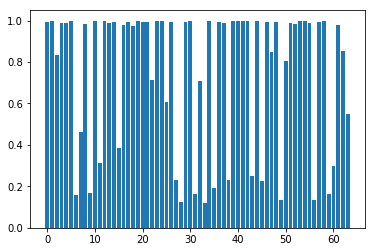

In [7]:
print(len(SEMasks))
SEMasks = np.array(SEMasks)
avg_masks = np.mean(np.concatenate(SEMasks,axis=0),axis=0)
print(avg_masks.shape)
avg_masks = np.reshape(avg_masks,(64,))
# avg_masks = np.mean(np.reshape(avg_masks,(64,64)),axis=1)
    
plt.figure()
plt.bar(range(len(avg_masks)),avg_masks)
plt.show()